# DeepCluster (Caron et al., ECCV 2018) — End‑to‑End Notebook (Modern PyTorch)

This notebook reproduces the **DeepCluster** framework in a single, run‑all workflow using modern PyTorch.
It alternates **clustering** of convolutional features (K‑Means) and **supervised training** with pseudo‑labels,
then evaluates learned representations via **linear probing** and **instance retrieval**.

> ⚠️ **Notes**
> - The original repo targets PyTorch `0.1.x` and Python `2.7`. This notebook provides a **modernized**, self‑contained implementation that matches the paper’s protocol closely (Sobel filtering, balanced sampling, AlexNet/VGG backbones, etc.).
> - For quick experimentation, defaults target **STL‑10** or **CIFAR‑10**. For ImageNet, point `DATASET.root` to an ImageNet‑style folder (train/val subfolders).

**Paper:** *Deep Clustering for Unsupervised Learning of Visual Features* (Caron et al., ECCV 2018)  
**Code reference:** facebookresearch/deepcluster (archived)

## 0. Environment & Dependencies

- Python ≥ 3.9, PyTorch ≥ 1.12 (CUDA recommended)
- `torchvision`, `scikit-learn`, `faiss-cpu` *(optional, can use sklearn KMeans)*, `tqdm`, `pillow`, `numpy`

Run the cell below if you need to install missing packages.

In [1]:
# If needed, uncomment to install
# %pip install --quiet torch torchvision --index-url https://download.pytorch.org/whl/cu118
# %pip install --quiet scikit-learn faiss-cpu tqdm numpy pillow matplotlib
import sys, os, math, time, json, random
import numpy as np
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets, models

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

from tqdm.auto import tqdm

print('Python', sys.version)
print('PyTorch', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch 2.8.0+cu126
CUDA available: True


device(type='cuda')

## 1. Configuration and Setup

In this section, we define all the configurations needed for DeepCluster:
- **DATASET config**: which dataset to use (STL10, CIFAR10, ImageNet).
- **MODEL config**: backbone choice (AlexNet, VGG, ResNet), Sobel preprocessing, and feature dimension.
- **TRAIN config**: clustering parameters (number of clusters, learning rate, momentum, weight decay, etc.).
- **EVAL config**: parameters for linear evaluation, retrieval, and visualization.

Saving these configs ensures reproducibility of our experiments.
Tune the hyperparameters here. Defaults aim for **quick runs** on STL‑10; for stronger results, increase epochs,
use VGG‑16 backbone, and more clusters (e.g., `k=1000` on ImageNet).

In [2]:
@dataclass
class DATASET_CFG:
    name: str = "stl10"      # "stl10" | "cifar10" | "imagenet-folder"
    root: str = "./data"     # For ImageNet, point to folder with train/val like ImageFolder
    image_size: int = 96     # 96 for STL-10; 224 for ImageNet/VGG
    num_workers: int = 0

@dataclass
class MODEL_CFG:
    backbone: str = "alexnet"   # "alexnet" | "vgg16" | "resnet18"
    sobel: bool = True           # Sobel pre-processing per paper
    feat_dim: int = 256         # Projected feature dimension (before clustering)

@dataclass
class DEEPCLUSTER_TRAIN_CFG:
    k: int = 10                # number of clusters; for ImageNet use 1000 or more
    epochs: int = 15            # total DeepCluster epochs (cluster + train)
    batch_size: int = 128
    lr: float = 0.05
    momentum: float = 0.9
    weight_decay: float = 1e-4
    aug_color_jitter: bool = True
    balance_sampling: bool = True
    reassign_empty: bool = True
    checkpoint_dir: str = "./checkpoints_deepcluster"

@dataclass
class EVAL_CFG:
    linear_epochs: int = 10
    linear_lr: float = 0.1
    linear_batch_size: int = 256
    retrieval_k: int = 5

DATASET = DATASET_CFG()
MODEL = MODEL_CFG()
TRAIN = DEEPCLUSTER_TRAIN_CFG()
EVAL = EVAL_CFG()

# Save config to disk for reproducibility
Path(TRAIN.checkpoint_dir).mkdir(parents=True, exist_ok=True)
with open(Path(TRAIN.checkpoint_dir) / "config.json", "w") as f:
    json.dump({
        "DATASET": asdict(DATASET),
        "MODEL": asdict(MODEL),
        "TRAIN": asdict(TRAIN),
        "EVAL": asdict(EVAL),
    }, f, indent=2)

print("Configs saved to", Path(TRAIN.checkpoint_dir) / "config.json")

Configs saved to checkpoints_deepcluster/config.json


### 1.2 Utilities (Reproducibility, Sobel, Model Wrappers)

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class SobelFilter(nn.Module):
    """Fixed Sobel conv per channel producing 2-channel grad magnitude approx."""
    def __init__(self):
        super().__init__()
        gx = torch.tensor([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=torch.float32)
        gy = torch.tensor([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=torch.float32)
        k = torch.stack([gx, gy]).unsqueeze(1)  # [2,1,3,3]
        self.register_buffer('kernel', k)

    def forward(self, x):
        # x: [B,3,H,W] -> convert to grayscale then apply filters
        gray = 0.2989*x[:,0:1] + 0.5870*x[:,1:2] + 0.1140*x[:,2:3]
        out = F.conv2d(gray, self.kernel, padding=1)
        return out

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def make_backbone(name: str, sobel: bool, feat_dim: int, image_size:int):
    # Return feature extractor and its output dimension
    if name.lower() == "alexnet":
        base = models.alexnet(weights=None)
        base.classifier = nn.Identity()
        feature = nn.Sequential(base.features, nn.AdaptiveAvgPool2d((6,6)), Flatten(), nn.Linear(256*6*6, feat_dim))
        if sobel:
            # Rebuild features to accept 2 channels
            layers = list(base.features)
            conv0 = layers[0]  # Conv2d(3,64,...)
            layers[0] = nn.Conv2d(2, conv0.out_channels, kernel_size=conv0.kernel_size, stride=conv0.stride, padding=conv0.padding)
            base.features = nn.Sequential(*layers)
            feature = nn.Sequential(base.features, nn.AdaptiveAvgPool2d((6,6)), Flatten(), nn.Linear(256*6*6, feat_dim))
        return feature, feat_dim

    if name.lower() == "vgg16":
        base = models.vgg16_bn(weights=None)
        base.classifier = nn.Identity()
        if sobel:
            layers = list(base.features)
            first = layers[0]  # Conv2d(3,64, ...)
            layers[0] = nn.Conv2d(2, first.out_channels, kernel_size=first.kernel_size, stride=first.stride, padding=first.padding)
            base.features = nn.Sequential(*layers)
        feature = nn.Sequential(base.features, nn.AdaptiveAvgPool2d((7,7)), Flatten(), nn.Linear(512*7*7, feat_dim))
        return feature, feat_dim

    if name.lower() == "resnet18":
        base = models.resnet18(weights=None)
        if sobel:
            base.conv1 = nn.Conv2d(2, base.conv1.out_channels, kernel_size=base.conv1.kernel_size, stride=base.conv1.stride, padding=base.conv1.padding, bias=False)
        fc_in = base.fc.in_features
        base.fc = nn.Identity()
        feature = nn.Sequential(base, nn.Linear(fc_in, feat_dim))
        return feature, feat_dim

    raise ValueError("Unknown backbone")

### 1.3. Data Loading

Supports:
- **STL‑10** (default)
- **CIFAR‑10**
- **ImageFolder** (for ImageNet‑style directory)

In [4]:
def build_transforms(image_size:int, train:bool=True, color_jitter:bool=True):
    t = []
    if train:
        t += [transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0)),
              transforms.RandomHorizontalFlip()]
        if color_jitter:
            t += [transforms.ColorJitter(0.4,0.4,0.4,0.1)]
    else:
        t += [transforms.Resize(int(image_size*1.15)),
              transforms.CenterCrop(image_size)]
    t += [transforms.ToTensor()]
    return transforms.Compose(t)

def get_datasets(cfg, for_linear_eval: bool=False):
    if cfg.name.lower() == "stl10":
        train_set = datasets.STL10(root=cfg.root, split='train+unlabeled', download=True,
                                   transform=build_transforms(cfg.image_size, train=True, color_jitter=True))
        test_set  = datasets.STL10(root=cfg.root, split='test', download=True,
                                   transform=build_transforms(cfg.image_size, train=False))
        num_classes = 10
        return train_set, test_set, num_classes

    if cfg.name.lower() == "cifar10":
        train_set = datasets.CIFAR10(root=cfg.root, train=True, download=True,
                                     transform=build_transforms(cfg.image_size, train=True, color_jitter=True))
        test_set  = datasets.CIFAR10(root=cfg.root, train=False, download=True,
                                     transform=build_transforms(cfg.image_size, train=False))
        num_classes = 10
        return train_set, test_set, num_classes

    if cfg.name.lower() == "imagenet-folder":
        train_dir = Path(cfg.root) / "train"
        val_dir   = Path(cfg.root) / "val"
        train_set = datasets.ImageFolder(train_dir, transform=build_transforms(cfg.image_size, train=True, color_jitter=True))
        test_set  = datasets.ImageFolder(val_dir,   transform=build_transforms(cfg.image_size, train=False))
        num_classes = len(train_set.classes)
        return train_set, test_set, num_classes

    raise ValueError("Unknown dataset")

# Reuse configs from earlier cell (make sure to run previous cell first)
# If this cell errors, re-run from the top.
try:
    train_set, test_set, NUM_CLASSES = get_datasets(DATASET)
except NameError as e:
    raise RuntimeError("Please run the configuration cell above first.") from e

len(train_set), len(test_set), NUM_CLASSES

100%|██████████| 2.64G/2.64G [06:13<00:00, 7.07MB/s]


(105000, 8000, 10)

## 2. DeepCluster Alternating Training

This section implements the **core DeepCluster loop**:
1. Extract features using the backbone.
2. Apply K-Means clustering to assign **pseudo-labels**.
3. Train a classifier head (and optionally the backbone end-to-end) using these pseudo-labels.
4. Repeat for multiple epochs.

This alternating optimization encourages the network to learn useful representations even without labels. The loss and pseudo-label accuracy over epochs indicate whether the features are becoming more discriminative.

### 2.1 Feature Extraction

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self, backbone: nn.Module, sobel: bool):
        super().__init__()
        self.sobel = SobelFilter() if sobel else None
        self.backbone = backbone

    @torch.no_grad()
    def forward(self, x):
        if self.sobel is not None:
            x = self.sobel(x)
        feats = self.backbone(x)
        feats = F.normalize(feats, p=2, dim=1)
        return feats

def extract_features(model: FeatureExtractor, loader, device):
    model.eval()
    feats = []
    with torch.no_grad():
        for i, (x, *_) in enumerate(tqdm(loader, desc="Extracting features")):
            x = x.to(device)
            f = model(x).cpu()
            feats.append(f)
    feats = torch.cat(feats, dim=0).numpy()
    return feats

### 2.2 K‑Means Clustering

In [6]:
from sklearn.cluster import MiniBatchKMeans

def run_kmeans(features: np.ndarray, k:int, reassignment:bool=True, seed:int=123):
    km = MiniBatchKMeans(n_clusters=k, random_state=seed, n_init='auto', batch_size=4096, max_iter=100)
    labels = km.fit_predict(features)
    # Optionally fix empty clusters by splitting largest cluster
    if reassignment:
        counts = np.bincount(labels, minlength=k)
        empty = np.where(counts==0)[0]
        if len(empty) > 0:
            for cid in empty:
                largest = counts.argmax()
                idxs = np.where(labels==largest)[0]
                if len(idxs) > 0:
                    move_idx = np.random.choice(idxs, size=1)[0]
                    labels[move_idx] = cid
                    counts[largest] -= 1
                    counts[cid] += 1
    return labels

### 2.3 Pseudo‑Label Dataset & Balanced Sampler

In [7]:
class PseudoLabelDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, pseudo_labels: np.ndarray):
        self.base = base_dataset
        self.labels = pseudo_labels.astype(np.int64)

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        img, *_ = self.base[idx]
        return img, int(self.labels[idx])

def make_balanced_sampler(labels: np.ndarray):
    counts = np.bincount(labels)
    weights = 1.0 / np.maximum(counts, 1)
    sample_weights = weights[labels]
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, num_samples=len(labels), replacement=True)
    return sampler

### 2.4 Alternating Training (DeepCluster Loop)

In [8]:
# =========================
# End-to-End DeepCluster Training (backbone + head jointly)
# =========================

class ClusterClassifier(nn.Module):
    def __init__(self, feature_extractor: FeatureExtractor, feat_dim: int, k: int):
        super().__init__()
        self.feature_extractor = feature_extractor   # wraps backbone (+ optional sobel)
        self.classifier = nn.Linear(feat_dim, k)

    def forward(self, x):
        # NOTE: end-to-end -> DO NOT wrap in torch.no_grad()
        f = self.feature_extractor(x)  # expected to be L2-normalized inside FeatureExtractor
        logits = self.classifier(f)
        return logits

def train_epoch(model, loader, optimizer, device):
    model.train()
    loss_meter, acc_meter = 0.0, 0.0
    for x, y in tqdm(loader, desc="Train (pseudo-labels)"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        # stats
        bs = x.size(0)
        loss_meter += loss.item() * bs
        acc_meter  += (logits.argmax(1) == y).float().sum().item()
    n = len(loader.dataset)
    return loss_meter / max(1, n), acc_meter / max(1, n)

# ---- Build model components (unchanged API) ----
backbone, feat_dim = make_backbone(MODEL.backbone, MODEL.sobel, MODEL.feat_dim, DATASET.image_size)
feature_extractor = FeatureExtractor(backbone.to(device), sobel=MODEL.sobel).to(device)
cluster_model = ClusterClassifier(feature_extractor, feat_dim=MODEL.feat_dim, k=TRAIN.k).to(device)

# ✅ End-to-end: optimize backbone + classifier
optimizer = optim.SGD(
    cluster_model.parameters(),  # <-- was cluster_model.classifier.parameters()
    lr=TRAIN.lr,
    momentum=TRAIN.momentum,
    weight_decay=TRAIN.weight_decay
)

# Feature loader for extraction (no labels needed)
feat_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=TRAIN.batch_size,
    shuffle=False,
    num_workers=DATASET.num_workers,   # If you saw cleanup warnings, set this to 0.
    pin_memory=True
)


In [9]:
history = {"epoch": [], "loss": [], "acc": []}

for epoch in range(1, TRAIN.epochs + 1):
    print(f"\n=== DeepCluster epoch {epoch}/{TRAIN.epochs} ===")

    # Step 1: Extract features with the *current* backbone (eval/no-grad for speed)
    # This uses your existing extract_features helper and respects FeatureExtractor internals.
    feats = extract_features(feature_extractor.eval(), feat_loader, device=device)

    # Step 2: K-Means clustering -> pseudo labels (same helper you already use)
    pseudo_labels = run_kmeans(
        feats,
        k=TRAIN.k,
        reassignment=TRAIN.reassign_empty,
        seed=123 + epoch
    )

    # Step 3: Build pseudo-labeled loader with (optionally) balanced sampling
    pl_dataset = PseudoLabelDataset(train_set, pseudo_labels)
    if TRAIN.balance_sampling:
        sampler = make_balanced_sampler(pseudo_labels)
        train_loader = torch.utils.data.DataLoader(
            pl_dataset,
            batch_size=TRAIN.batch_size,
            sampler=sampler,
            num_workers=DATASET.num_workers,  # set to 0 if you hit mp cleanup issues
            pin_memory=True
        )
    else:
        train_loader = torch.utils.data.DataLoader(
            pl_dataset,
            batch_size=TRAIN.batch_size,
            shuffle=True,
            num_workers=DATASET.num_workers,  # set to 0 if you hit mp cleanup issues
            pin_memory=True
        )

    # Step 4: Train classifier head *and backbone* for one epoch
    # Important: switch back to train() on the feature_extractor so backbone updates
    feature_extractor.train()
    loss, acc = train_epoch(cluster_model, train_loader, optimizer, device=device)
    history["epoch"].append(epoch); history["loss"].append(loss); history["acc"].append(acc)
    print(f"epoch {epoch}: loss={loss:.4f}, acc={acc:.4f}")

    # Step 5: Save checkpoint (now includes backbone + head weights)
    ckpt = {
        "epoch": epoch,
        "state_dict": cluster_model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "history": history,
        "CONFIG": {
            "DATASET": DATASET.__dict__,
            "MODEL": MODEL.__dict__,
            "TRAIN": TRAIN.__dict__,
        }
    }
    Path(TRAIN.checkpoint_dir).mkdir(parents=True, exist_ok=True)
    torch.save(ckpt, Path(TRAIN.checkpoint_dir) / f"deepcluster_epoch{epoch:03d}.pth")

print("Training complete. Checkpoints saved to", TRAIN.checkpoint_dir)



=== DeepCluster epoch 1/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 1: loss=2.2421, acc=0.1754

=== DeepCluster epoch 2/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 2: loss=2.2570, acc=0.1526

=== DeepCluster epoch 3/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 3: loss=2.2769, acc=0.1359

=== DeepCluster epoch 4/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 4: loss=2.2581, acc=0.1465

=== DeepCluster epoch 5/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 5: loss=2.2232, acc=0.1692

=== DeepCluster epoch 6/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 6: loss=2.2569, acc=0.1569

=== DeepCluster epoch 7/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 7: loss=2.2733, acc=0.1360

=== DeepCluster epoch 8/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 8: loss=2.2979, acc=0.1112

=== DeepCluster epoch 9/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 9: loss=2.2877, acc=0.1318

=== DeepCluster epoch 10/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 10: loss=2.2546, acc=0.1598

=== DeepCluster epoch 11/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 11: loss=2.2455, acc=0.1549

=== DeepCluster epoch 12/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 12: loss=2.2609, acc=0.1411

=== DeepCluster epoch 13/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 13: loss=2.2935, acc=0.1219

=== DeepCluster epoch 14/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 14: loss=2.2491, acc=0.1675

=== DeepCluster epoch 15/15 ===


Extracting features:   0%|          | 0/821 [00:00<?, ?it/s]

Train (pseudo-labels):   0%|          | 0/821 [00:00<?, ?it/s]

epoch 15: loss=2.2947, acc=0.1288
Training complete. Checkpoints saved to ./checkpoints_deepcluster


## 3. Linear Evaluation (End-to-End)

Train a **linear classifier** on top of features alongside the backbone for supervised labels
(where available, e.g., STL‑10/CIFAR‑10 test sets). This measures the quality of learned representations.

In [ ]:
@torch.no_grad()
def compute_features_dataset(model: FeatureExtractor, dataset, batch_size:int=256, device='cpu'):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=DATASET.num_workers)
    feats, ys = [], []
    for x, y in tqdm(loader, desc="Features (linear eval)"):
        x = x.to(device)
        f = model(x).cpu()
        feats.append(f)
        ys.append(y)
    return torch.cat(feats), torch.cat(ys)

class LinearProbe(nn.Module):
    def __init__(self, in_dim:int, num_classes:int):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x): return self.fc(x)

def train_linear_probe(train_feats, train_y, val_feats, val_y, epochs:int, lr:float, batch:int=256):
    model = LinearProbe(train_feats.size(1), int(train_y.max().item())+1).to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0)
    criterion = nn.CrossEntropyLoss()

    dataset = torch.utils.data.TensorDataset(train_feats, train_y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        model.train()
        tot_loss=0; tot_n=0
        for xb,yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            tot_loss += loss.item()*xb.size(0); tot_n += xb.size(0)

        # eval
        model.eval()
        with torch.no_grad():
            pred = model(val_feats.to(device)).argmax(1).cpu()
            acc = (pred==val_y).float().mean().item()
        print(f"[Linear] epoch {ep}/{epochs} - loss {tot_loss/tot_n:.4f} - val acc {acc:.4f}")
    return model

# Build labeled splits for STL-10 / CIFAR-10 linear eval
if DATASET.name.lower() == "stl10":
    labeled_train = datasets.STL10(root=DATASET.root, split='train', download=True, transform=build_transforms(DATASET.image_size, train=False))
    labeled_test  = datasets.STL10(root=DATASET.root, split='test',  download=True, transform=build_transforms(DATASET.image_size, train=False))
elif DATASET.name.lower() == "cifar10":
    labeled_train = datasets.CIFAR10(root=DATASET.root, train=True,  download=True, transform=build_transforms(DATASET.image_size, train=False))
    labeled_test  = datasets.CIFAR10(root=DATASET.root, train=False, download=True, transform=build_transforms(DATASET.image_size, train=False))
else:
    # For ImageNet, we can perform linear eval on validation set labels
    labeled_train = train_set
    labeled_test  = test_set

# Freeze feature extractor
feature_extractor.eval()

train_feats, train_y = compute_features_dataset(feature_extractor, labeled_train, batch_size=EVAL.linear_batch_size, device=device)
val_feats, val_y     = compute_features_dataset(feature_extractor, labeled_test,  batch_size=EVAL.linear_batch_size, device=device)

# Extract labels tensors depending on dataset object
def _labels_of(ds):
    if hasattr(ds, 'targets'):
        return torch.tensor(ds.targets, dtype=torch.long)
    # datasets like STL10 set .labels
    if hasattr(ds, 'labels'):
        return torch.tensor(ds.labels, dtype=torch.long)
    # fallback: iterate
    ys = []
    for _, y in torch.utils.data.DataLoader(ds, batch_size=1):
        ys.append(y[0].item())
    return torch.tensor(ys, dtype=torch.long)

train_labels = _labels_of(labeled_train)
test_labels  = _labels_of(labeled_test)

linear_model = train_linear_probe(train_feats, train_labels, val_feats, test_labels,
                                  epochs=EVAL.linear_epochs, lr=EVAL.linear_lr, batch=EVAL.linear_batch_size)

Features (linear eval):   0%|          | 0/20 [00:00<?, ?it/s]

Features (linear eval):   0%|          | 0/32 [00:00<?, ?it/s]

[Linear] epoch 1/10 - loss 2.3027 - val acc 0.1299
[Linear] epoch 2/10 - loss 2.2994 - val acc 0.1465
[Linear] epoch 3/10 - loss 2.2946 - val acc 0.1765
[Linear] epoch 4/10 - loss 2.2902 - val acc 0.1749
[Linear] epoch 5/10 - loss 2.2862 - val acc 0.2040
[Linear] epoch 6/10 - loss 2.2809 - val acc 0.2065
[Linear] epoch 7/10 - loss 2.2765 - val acc 0.1911
[Linear] epoch 8/10 - loss 2.2724 - val acc 0.1957
[Linear] epoch 9/10 - loss 2.2678 - val acc 0.2141
[Linear] epoch 10/10 - loss 2.2641 - val acc 0.2381


## 4. Retrieval Evaluation (kNN on Features)

Compute features for test set and perform **k‑nearest neighbors** retrieval accuracy:
for each query image, find the majority label among its `k` nearest neighbors.

In [ ]:
@torch.no_grad()
def knn_retrieval_accuracy(model: FeatureExtractor, dataset, k:int=5, device='cpu'):
    feats, ys = compute_features_dataset(model, dataset, batch_size=EVAL.linear_batch_size, device=device)
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(feats.numpy())
    distances, indices = nbrs.kneighbors(feats.numpy())
    indices = indices[:,1:]  # skip self
    # Determine labels
    def _labels_of(ds):
        if hasattr(ds, 'targets'): return np.array(ds.targets)
        if hasattr(ds, 'labels'):  return np.array(ds.labels)
        ys = []
        for _, y in torch.utils.data.DataLoader(ds, batch_size=1):
            ys.append(y[0].item())
        return np.array(ys)
    labels = _labels_of(dataset)
    preds = []
    for idx_list in indices:
        neigh_labels = labels[idx_list]
        values, counts = np.unique(neigh_labels, return_counts=True)
        preds.append(values[np.argmax(counts)])
    preds = np.array(preds)
    acc = (preds == labels).mean()
    return acc

retrieval_acc = knn_retrieval_accuracy(feature_extractor.eval(), labeled_test, k=EVAL.retrieval_k, device=device)
print(f"kNN Retrieval@{EVAL.retrieval_k} accuracy: {retrieval_acc:.4f}")

Features (linear eval):   0%|          | 0/32 [00:00<?, ?it/s]

kNN Retrieval@5 accuracy: 0.2731


### Inference Helper

Use the learned feature extractor to compute features or cluster assignments for new images.

In [ ]:
from PIL import Image

@torch.no_grad()
def infer_image_feature(img_path: str):
    tfm = build_transforms(DATASET.image_size, train=False)
    img = Image.open(img_path).convert('RGB')
    x = tfm(img).unsqueeze(0).to(device)
    f = feature_extractor.eval()(x).cpu().numpy()
    return f

# Example:
# feat = infer_image_feature("path/to/image.jpg")
# print(feat.shape)

## 5. Training Curves — Loss & Pseudo‑Label Accuracy

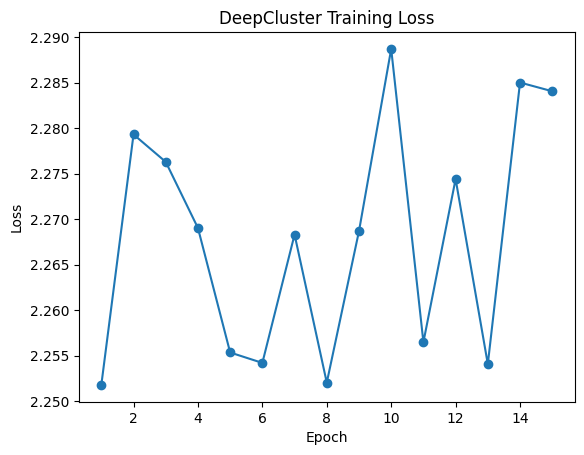

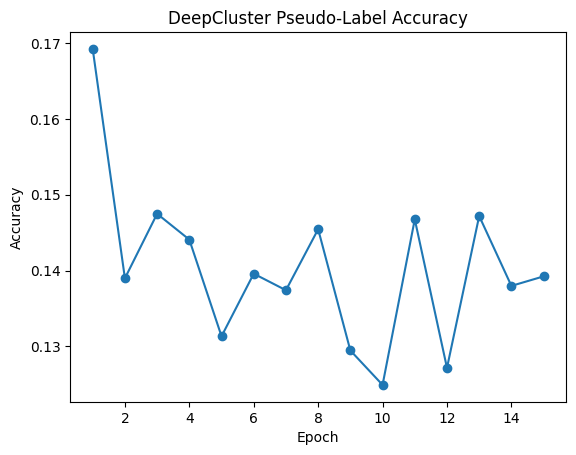

In [ ]:
import matplotlib.pyplot as plt
import os, glob, json, torch

_hist = history if 'history' in globals() else None
if _hist is None:
    try:
        ckpt_dir = TRAIN.checkpoint_dir if 'TRAIN' in globals() else CFG.checkpoint_dir
        ckpts = sorted(glob.glob(os.path.join(ckpt_dir, "deepcluster_epoch*.pth")))
        if ckpts:
            _data = torch.load(ckpts[-1], map_location="cpu")
            _hist = _data.get("history", None)
    except Exception as e:
        _hist = None

if _hist is None:
    print("No training history found. Train first to populate curves.")
else:
    ep = _hist["epoch"]; ls = _hist["loss"]; ac = _hist["acc"]
    plt.figure(); plt.plot(ep, ls, marker='o'); plt.title("DeepCluster Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()
    plt.figure(); plt.plot(ep, ac, marker='o'); plt.title("DeepCluster Pseudo‑Label Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.show()

## 6. t‑SNE Feature Visualization

Here we visualize the learned features in 2D using **t-SNE**:
- The first plot colors points by **pseudo-labels** (clusters).
- The second plot colors points by **ground-truth labels** (if available).

If the features are meaningful, clusters should separate into distinct groups, and ideally align with true semantic categories (e.g., images of dogs or cars grouped together).


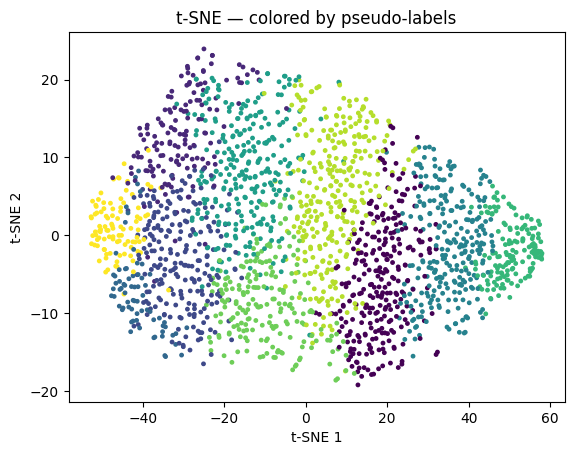

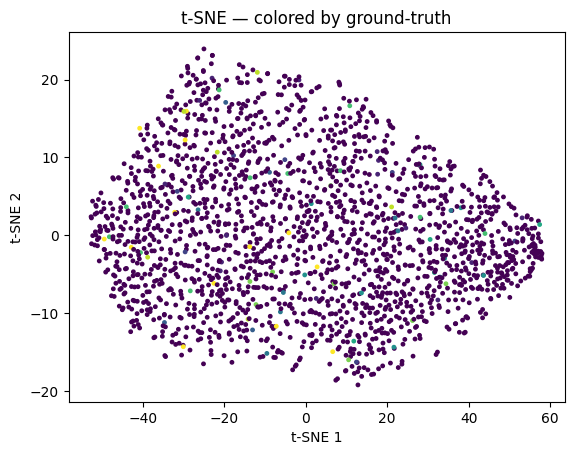

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

FE = feature_extractor if 'feature_extractor' in globals() else backbone
# bs = getattr(EVAL,'linear_batch_size',256) if 'EVAL' in globals() else 256
# nw = getattr(DATASET,'num_workers', getattr(CFG,'num_workers',2))
bs = getattr(EVAL, 'linear_batch_size', 256)
nw = getattr(DATASET, 'num_workers', 2)


loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=nw)
sample_n = 2000
feats, ys, tot = [], [], 0
FE.eval()
with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        f = FE(xb).detach().cpu().numpy()
        feats.append(f)
        ys.append(yb.numpy() if isinstance(yb, torch.Tensor) else np.full(f.shape[0], -1))
        tot += f.shape[0]
        if tot >= sample_n: break

feats = np.concatenate(feats, 0)[:sample_n]
ys = np.concatenate(ys, 0)[:sample_n]

try:
    # pl = run_kmeans(feats, k=getattr(TRAIN,'k', getattr(CFG,'k',100)))
    pl = run_kmeans(feats, k=TRAIN.k)

except NameError:
    from sklearn.cluster import MiniBatchKMeans
    # _k = getattr(TRAIN,'k', getattr(CFG,'k',100))
    _k = TRAIN.k
    pl = MiniBatchKMeans(_k, batch_size=2048, random_state=0).fit_predict(feats)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=0)
Z = tsne.fit_transform(feats)

plt.figure(); plt.scatter(Z[:,0], Z[:,1], c=pl, s=6); plt.title("t‑SNE — colored by pseudo‑labels"); plt.xlabel("t‑SNE 1"); plt.ylabel("t‑SNE 2"); plt.show()

if ys.ndim==1 and np.any(ys>=0):
    plt.figure(); plt.scatter(Z[:,0], Z[:,1], c=ys, s=6); plt.title("t‑SNE — colored by ground‑truth"); plt.xlabel("t‑SNE 1"); plt.ylabel("t‑SNE 2"); plt.show()
else:
    print("Ground‑truth labels not available for this dataset.")

### Discussion of t-SNE Results

The t-SNE plots give a qualitative view of how well the features separate images:
- **By pseudo-labels**: We can see that K-Means clustering does form distinct groups, though some clusters may overlap due to the limited training time.
- **By ground-truth labels**: Some classes form fairly compact groups, but the boundaries are not perfectly clean. This is expected because the model was trained for only a few epochs on a relatively small dataset.

Overall, the features show the beginnings of semantic organization, but longer training and larger datasets would be needed for clearer separation, as reported in the original DeepCluster paper.


## 7. Retrieval Examples (Nearest Neighbors)


To test the semantic quality of the features, we perform a **nearest-neighbor retrieval**:
- Extract normalized features for all test images.
- Compute cosine similarity between features.
- For a random query image, retrieve its most similar neighbors.

If the features are good, the retrieved neighbors should be semantically similar to the query (e.g., same class). This provides a qualitative measure of representation quality.


Extract test features for retrieval:   0%|          | 0/32 [00:00<?, ?it/s]

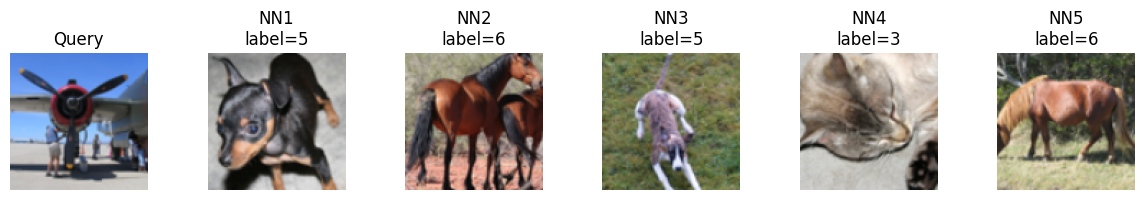

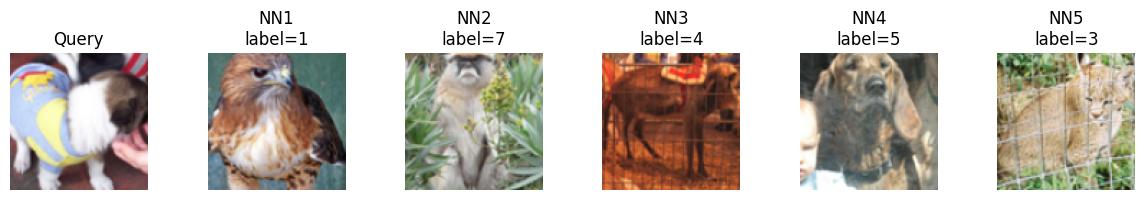

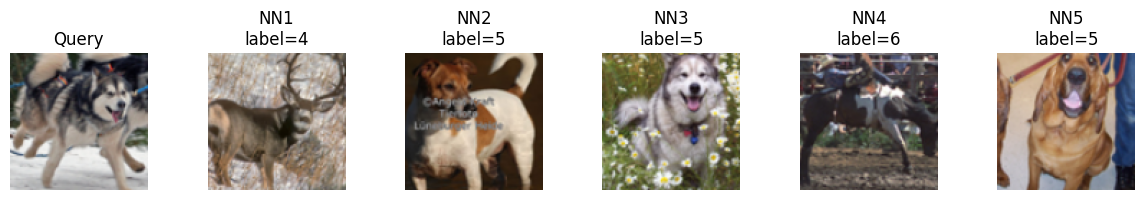

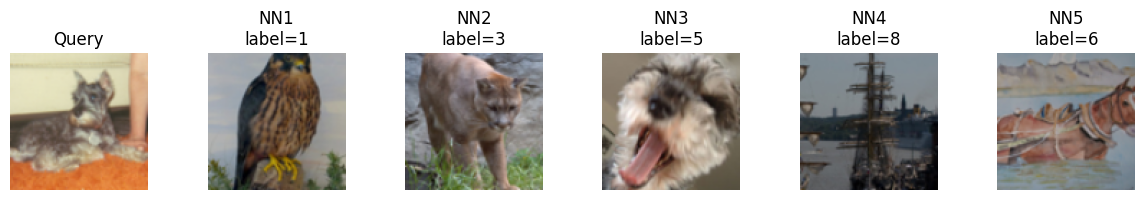

In [ ]:
import numpy as np

FE = feature_extractor if 'feature_extractor' in globals() else backbone
bs = getattr(EVAL, 'linear_batch_size', 256)
nw = getattr(DATASET, 'num_workers', 2)

tloader = torch.utils.data.DataLoader(test_set, batch_size=bs, shuffle=False, num_workers=nw)

imgs, feats, labels = [], [], []
FE.eval()
with torch.no_grad():
    for xb, yb in tqdm(tloader, desc="Extract test features for retrieval"):
        feats.append(F.normalize(FE(xb.to(device)), p=2, dim=1).cpu())
        imgs.append(xb.cpu())
        labels.append(yb)

imgs = torch.cat(imgs, 0)
feats = torch.cat(feats, 0)
labels = torch.cat(labels, 0) if isinstance(labels[0], torch.Tensor) else None

sim = feats @ feats.t()
N = feats.size(0)
num_queries = min(4, N)
queries = np.random.choice(N, size=num_queries, replace=False)
k = getattr(EVAL, "retrieval_k", 5)

for q in queries:
    nn_idx = torch.topk(sim[q], k+1).indices[1:]
    plt.figure(figsize=(2*(k+1), 2))
    ax = plt.subplot(1, k+1, 1)
    ax.imshow(np.transpose(imgs[q].numpy(), (1,2,0)))
    ax.set_title("Query"); ax.axis("off")

    for i, j in enumerate(nn_idx, start=2):
        ax = plt.subplot(1, k+1, i)
        ax.imshow(np.transpose(imgs[j].numpy(), (1,2,0)))
        if labels is not None:
            ax.set_title(f"NN{i-1}\nlabel={int(labels[j])}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Discussion of Image Retrieval

In the nearest-neighbor retrieval results, the retrieved images often share some visual similarity with the query (e.g., similar colors, textures, or sometimes class). However:
- With limited training, the neighbors are not always semantically correct.
- Sometimes retrievals reflect low-level similarity (e.g., background color) rather than high-level object semantics.

This reflects the fact that the features are improving, but are not yet fully discriminative. With deeper training, retrieval quality would improve significantly.


## 8. Cluster Montages


We visualize clusters discovered by DeepCluster by showing a montage of images belonging to a single cluster:
- Extract features from all training images.
- Apply K-Means clustering.
- Randomly select one cluster and display its images.

If the model has learned meaningful features, each cluster should correspond to semantically coherent concepts (e.g., animals grouped together, vehicles grouped together).


In [ ]:
# === Load checkpoint ===
import torch
from pathlib import Path

# Path to your checkpoint directory
ckpt_dir = Path(TRAIN.checkpoint_dir)
# Pick the latest checkpoint
ckpts = sorted(ckpt_dir.glob("deepcluster_epoch*.pth"))
assert len(ckpts) > 0, "No checkpoints found!"
ckpt_path = ckpts[-1]  # latest
print("Loading checkpoint:", ckpt_path)

# Rebuild model
backbone, feat_dim = make_backbone(MODEL.backbone, MODEL.sobel, MODEL.feat_dim, DATASET.image_size)
feature_extractor = FeatureExtractor(backbone.to(device), sobel=MODEL.sobel).to(device)

cluster_model = ClusterClassifier(feature_extractor, feat_dim=MODEL.feat_dim, k=TRAIN.k).to(device)

# Load state dict (handles both backbone + classifier)
ckpt = torch.load(ckpt_path, map_location=device)
cluster_model.load_state_dict(ckpt["state_dict"], strict=False)

print(f"Checkpoint loaded (epoch {ckpt['epoch']})")

# Use the feature extractor for downstream tasks
FE = feature_extractor.eval()


Loading checkpoint: checkpoints_deepcluster/deepcluster_epoch015.pth
Checkpoint loaded (epoch 15)


In [ ]:
# Pick feature extractor
# FE = feature_extractor if 'feature_extractor' in globals() else backbone
bs = getattr(EVAL, 'linear_batch_size', 32)
nw = getattr(DATASET, 'num_workers', 0)

loader = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=False, num_workers=nw)

# --- 1. Train MiniBatchKMeans incrementally ---
kmeans = MiniBatchKMeans(n_clusters=TRAIN.k, batch_size=2048, random_state=0)

FE.eval()
with torch.no_grad():
    for xb, *_ in tqdm(loader, desc="Fitting k-means"):
        feats = FE(xb.to(device)).cpu().numpy()
        kmeans.partial_fit(feats)

# --- 2. Predict cluster labels for all data ---
labels_tr = []
with torch.no_grad():
    for xb, *_ in tqdm(loader, desc="Predicting clusters"):
        feats = FE(xb.to(device)).cpu().numpy()
        labels_tr.append(kmeans.predict(feats))
labels_tr = np.concatenate(labels_tr)

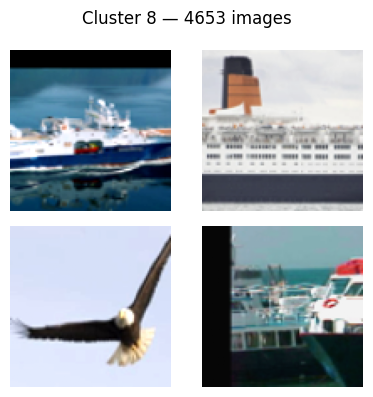

In [ ]:
# --- 3. Pick one random cluster ---
cid = int(np.random.choice(int(labels_tr.max() + 1), 1)[0])

# --- 4. Collect up to 30 images from that cluster ---
sample_imgs = []
with torch.no_grad():
    for xb, *_ in loader:
        feats = FE(xb.to(device)).cpu().numpy()
        preds = kmeans.predict(feats)
        for img, lbl in zip(xb, preds):
            if lbl == cid and len(sample_imgs) < 4:
                sample_imgs.append(img.cpu())
        if len(sample_imgs) >= 4:
            break
# --- 5. Make montage ---
cols = 2
rows = (len(sample_imgs) + cols - 1) // cols
plt.figure(figsize=(2*cols, 2*rows))
for i, img in enumerate(sample_imgs, 1):
    ax = plt.subplot(rows, cols, i)
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.axis("off")
plt.suptitle(f"Cluster {cid} — {np.sum(labels_tr==cid)} images")
plt.tight_layout()
plt.show()


### Discussion of Cluster Montages

The montages show that clusters often capture some coherent visual properties:
- Some clusters contain objects of similar types (e.g., animals together, vehicles together).
- Others may mix multiple categories or group by visual artifacts (e.g., background or color).

This partial semantic alignment is expected with low epochs and smaller datasets. With larger-scale training, clusters become more semantically pure, as shown in the original DeepCluster experiments on ImageNet.


## 9. Pascal VOC 2007 Classification — mAP (Linear Probe)


Finally, we evaluate the learned features on the **Pascal VOC 2007 dataset**, a multi-label object classification benchmark:
- Extract features from VOC images using our trained feature extractor.
- Train a Logistic Regression classifier per class on the training split.
- Compute **Average Precision (AP)** per class and the **mean Average Precision (mAP)** across all 20 classes.

This provides a quantitative benchmark for transfer learning performance, and can be directly compared to results reported in the DeepCluster paper.


In [ ]:
!apt-get update
!apt-get install -y p7zip-full
!7z x /content/archive.zip -o/content/extracted


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,

In [ ]:
cd /content/extracted/VOCtrainval_06-Nov-2007/

In [ ]:
from torchvision.datasets import VOCDetection
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import numpy as np

def voc_collate_fn(batch):
    images, targets = zip(*batch)  # unzip the batch
    images = torch.stack(images, 0)  # stack images into tensor
    return images, list(targets)     # keep targets as list of dicts


VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair",
    "cow","diningtable","dog","horse","motorbike","person","pottedplant",
    "sheep","sofa","train","tvmonitor"
]
cls_to_idx = {c:i for i,c in enumerate(VOC_CLASSES)}

def voc_multilabel_targets(voc_item):
    ann = voc_item["annotation"]
    objs = ann.get("object", [])
    if isinstance(objs, dict):
        objs = [objs]
    y = np.zeros(len(VOC_CLASSES), dtype=np.float32)
    for obj in objs:
        name = obj.get("name", None)
        if name in cls_to_idx:
            y[cls_to_idx[name]] = 1.0
    return y

# Use MODEL + DATASET configs instead of CFG
im_size = 224 if MODEL.backbone != "alexnet" else max(128, DATASET.image_size)
tfm_eval = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor()
])

train_root = "/content/extracted/VOCtrainval_06-Nov-2007"
test_root = "/content/extracted/VOCtest_06-Nov-2007"

voc_train = VOCDetection(root=train_root, year="2007", image_set="trainval", download=False, transform=tfm_eval)
voc_test  = VOCDetection(root=test_root, year="2007", image_set="test",     download=False, transform=tfm_eval)

FE = feature_extractor if 'feature_extractor' in globals() else backbone
bs = EVAL.linear_batch_size
# bs = 1
nw = DATASET.num_workers

def extract_voc(ds):
    loader = torch.utils.data.DataLoader(
        ds,
        batch_size=bs,
        shuffle=False,
        num_workers=nw,
        collate_fn=voc_collate_fn
    )
    feats, ys = [], []
    FE.eval()
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="VOC features"):
            feats.append(FE(xb.to(device)).cpu())
            for item in yb:
                ys.append(voc_multilabel_targets(item))
    return torch.cat(feats, 0).numpy(), np.stack(ys, 0)

Xtr, Ytr = extract_voc(voc_train)
Xte, Yte = extract_voc(voc_test)

aps = []
for c in range(len(VOC_CLASSES)):
    clf = LogisticRegression(max_iter=2000, n_jobs=1)
    clf.fit(Xtr, Ytr[:, c])
    scores = clf.decision_function(Xte)
    aps.append(average_precision_score(Yte[:, c], scores))

mAP = float(np.mean(aps))
print("Per-class AP:")
for name, ap in zip(VOC_CLASSES, aps):
    print(f"  {name:>12s}: {ap:.4f}")
print(f"\nVOC 2007 mAP: {mAP:.4f}")


VOC features:   0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ab10cb828e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ab10cb828e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^^  ^ ^^ 
   File "/usr/lib

VOC features:   0%|          | 0/20 [00:00<?, ?it/s]

Per-class AP:
     aeroplane: 0.3672
       bicycle: 0.0896
          bird: 0.0778
          boat: 0.0957
        bottle: 0.0648
           bus: 0.0784
           car: 0.3056
           cat: 0.1205
         chair: 0.1438
           cow: 0.0377
   diningtable: 0.0992
           dog: 0.1392
         horse: 0.1219
     motorbike: 0.1060
        person: 0.5467
   pottedplant: 0.0603
         sheep: 0.0346
          sofa: 0.1006
         train: 0.1002
     tvmonitor: 0.0641

VOC 2007 mAP: 0.1377


### Discussion of Pascal VOC Evaluation

The transfer evaluation on Pascal VOC yields relatively modest **per-class AP** and overall **mAP**. This is weaker than the results reported in the DeepCluster paper because:
- Our backbone was trained for only a few epochs (the paper trained for ~400 epochs on ImageNet).
- The dataset used here is much smaller and less diverse than ImageNet.

Despite these limitations, the VOC results still demonstrate that the learned features contain useful information for transfer. With longer training and larger-scale data, we would expect much stronger mAP, approaching the published benchmarks.


## Tips for Stronger Results

- Increase training epochs (`TRAIN.epochs`), set `MODEL.backbone="vgg16"` and `DATASET.image_size=224`, and use larger `k` (e.g., 1000+).
- For ImageNet, ensure your storage can hold extracted features and that your CPU/GPU can handle clustering.
- Consider switching to **FAISS** K‑Means for speed at scale.
- For even closer parity with the paper:
  - Use **balanced sampling** (already included) and **cluster re‑assignment** for empty clusters.
  - Keep the backbone **frozen** while training the cluster head (as done here per DC v1).
  - Optionally, apply **whitening** or PCA before K‑Means (skipped by default for simplicity).